------------------------------------------------------
|   Total de ejemplos en el dataset cargado: 60000   |
------------------------------------------------------
Clases disponibles: 10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
------------------------------------
|  Lado de las imágenes     :  80  |
------------------------------------
-------------------------------------------------
|  Objetivo de entrenamiento:  accuracy = 0.75  |
-------------------------------------------------
282/282 [==============================] - 698s 2s/step - loss: 1.9490 - accuracy: 0.3112
    Precisión en la vuelta 1:  31.12%
282/282 [==============================] - 652s 2s/step - loss: 1.5403 - accuracy: 0.4493
    Precisión en la vuelta 2:  44.93%
282/282 [==============================] - 598s 2s/step - loss: 1.2955 - accuracy: 0.5426
    Precisión en la vuelta 3:  54.26%
282/282 [==============================] - 569s 2s/step - loss: 1.1308 - ac

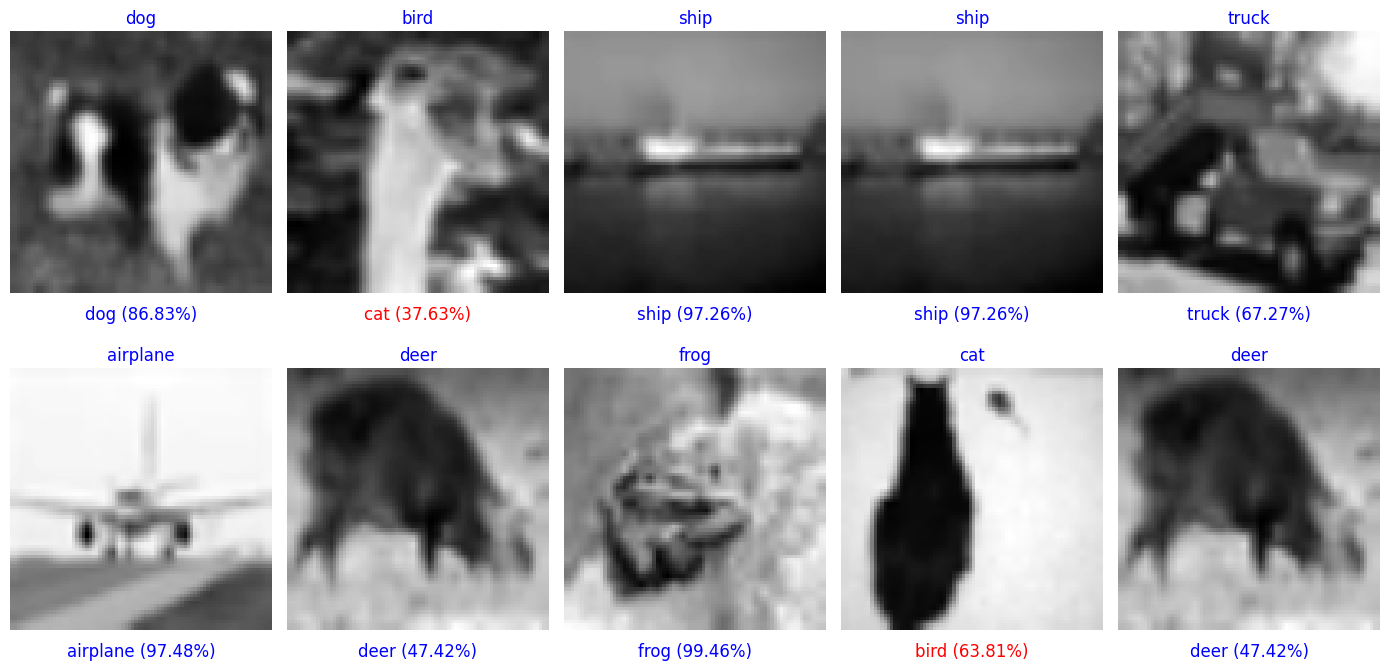

In [2]:
#-------------------------------------------------------------------------------
# 0. Constantes
#-------------------------------------------------------------------------------
SPLITS  = { 'test', 'train', 'validation' }

# Configuración inicial
LADO          = 80
TAMAÑO_IMAGEN = [LADO, LADO]
TAMAÑO_LOTE   = 128

# Definimos el tamaño de los splits
TRAIN = 0.60
TEST  = round( ( ( 1 - TRAIN ) / 1 ), 2 )

# Variables asociadas al modelo
TAMAÑO_KERNEL = ( 3, 3 )
TAMAÑO_POOL   = ( 2, 2 )
ACTIVACION_TIPO   = 'relu'
ACTIVACION_SALIDA = 'softmax'
INPUT_SHAPE       = ( LADO, LADO, 1 )
FILTROS = 32
DROPOUT = 0.25

# Variable asociada al entrenamiento
ACIERTOS = 0.7500

#-------------------------------------------------------------------------------
# FUNCIONES
#-------------------------------------------------------------------------------
def mostrarTexto( texto ):
    """
    Muestra un texto enmarcado con guiones por encima y por debajo.

    :param texto: El texto a mostrar en formato enmarcado.
    """
    longitud = len( texto )
    print( '-' * longitud )
    print( texto )
    print( '-' * longitud )

#-------------------------------------------------------------------------------
# 1. Importamos las librerías
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 2. Descargamos el dataset
#-------------------------------------------------------------------------------
def obtenerInformacionDataset( Dataset ):
    """
    Obtiene la información del dataset de TensorFlow Datasets.

    :param Dataset: Nombre del dataset (ej. 'cifar10').
    :return:        Información del dataset.
    """
    info = tfds.builder( Dataset ).info
    return info
#-------------------------------------------------------------------------------
def obtenerNombreDataset( Splits ):
    """
    Solicita al usuario un nombre de dataset de TensorFlow Datasets y verifica que el dataset
    tenga características de 'image' y 'label', y que incluya alguno de los splits requeridos.

    :param Splits: Conjunto de splits necesarios (ej. {'test', 'train', 'validation'}).
    :return: Una tupla con el nombre del dataset y su información.
    """
    while True:
        try:
            dataset = input( "Nombre del dataset (por ejemplo, 'cifar10'): ")
            info    = obtenerInformacionDataset( dataset )
            if "image" in info.features and "label" in info.features:
                splits = set( info.splits.keys() )
                if splits & Splits:
                    break  # Si no hay errores, salimos del bucle

        except Exception as e:
            print( "Error." )

    return dataset, info
#-------------------------------------------------------------------------------
def obtenerNumeroClases( Dataset ):
    """
    Obtiene el número de clases de un dataset de TensorFlow Datasets.

    :param Dataset: Nombre del dataset (ej. 'cifar10').
    :return: Número de clases del dataset.
    """
    info = tfds.builder( Dataset ).info
    return info.features[ 'label' ].num_classes
#-------------------------------------------------------------------------------
def obtenerNombreClases( Dataset ):
    """
    Obtiene los nombres de las clases de un dataset de TensorFlow Datasets.

    :param Dataset: Nombre del dataset (ej. 'cifar10').
    :return: Lista de nombres de las clases del dataset o None si ocurre un error.
    """
    info = obtenerInformacionDataset( Dataset )

    return info.features[ 'label' ].names
#-------------------------------------------------------------------------------
def cargarDataset( Dataset, Splits ):
    """
    Carga un dataset de TensorFlow Datasets con los splits especificados.

    :param Dataset: Nombre del dataset (ej. 'cifar10').
    :param Splits:  Lista de splits a cargar (ej. ['test', 'train', 'validation']).
    :return:        El dataset cargado.
    """
    info = obtenerInformacionDataset( Dataset )

    # Establecer as_supervised en True salvo que el dataset no soporte el modo supervisado
    as_supervised = True if info.supervised_keys else False

    datasetCargado = tfds.load( Dataset,
                                split='+'.join([split for split in Splits if split in info.splits]),
                                as_supervised = as_supervised,
                                download=True)

    return datasetCargado
#-------------------------------------------------------------------------------
def contarTuplasDataset( Dataset, Splits ):
    """
    Cuenta el número total de ejemplos en los splits especificados de un dataset de TensorFlow Datasets.

    :param Dataset: Nombre del dataset (ej. 'cifar10').
    :param Splits:  Lista de splits a contar (ej. ['test', 'train', 'validation']).
    :return:        Número total de ejemplos en los splits especificados.
    """
    info      = obtenerInformacionDataset( Dataset )
    numTuplas = sum( [ info.splits[ split ].num_examples for split in Splits if split in info.splits ] )

    return numTuplas
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
# 3. Agrupamos los datos en Entrenamiento (60%) y Prueba (40%)
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
# 4. Normalizamos las imágenes a blanco y negro, a un tamaño y las metemos en un buffer
#-------------------------------------------------------------------------------
# Función para normalizar imágenes
def NORMALIZAR( Imagenes, Etiquetas, TamañoImagen ):
    """
    Normaliza las imágenes y etiquetas para prepararlas para el entrenamiento.

    :param Imagenes: Tensor de imágenes.
    :param Etiquetas: Tensor de etiquetas correspondientes a las imágenes.
    :param TamañoImagen: Tupla (altura, anchura) para redimensionar las imágenes.
    :return: Tupla con las imágenes normalizadas y las etiquetas.
    """
    Imagenes = tf.image.resize( Imagenes, TamañoImagen )  # Redimensionar imágenes
    Imagenes = tf.cast( Imagenes, tf.float32 )            # Convertir a float32
    Imagenes = Imagenes / 255.0                           # Normalizar a rango [0, 1]
    if Imagenes.shape[-1] == 3:                           # Verificar si la imagen es RGB
        Imagenes = tf.image.rgb_to_grayscale( Imagenes )  # Convertir a escala de grises

    return Imagenes, Etiquetas
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 5. Cambiamos diversos aspectos de las imágenes
#-------------------------------------------------------------------------------


#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# 6. DEFINIMOS EL MODELO
#-------------------------------------------------------------------------------
# - Clasificación de capas del modelo
#
#   1.  Partes del modelo:
#       - Capa de entrada de datos:
#              Input( shape = ( altura, anchura, canales ) )
#              Conv2D( filters = 64, kernel_size = ( 3, 3 ), input_shape = ( 32, 32, 3 ) )
#                      filters         Número de filtros convolucionales
#                      kernel_size     Tamaño de la ventana de convulación. Si es un único valor, se duplica
#
#       - Capa de procesamiento de datos:
#              Conv2D( filters = 64, kernel_size = ( 3, 3 ), strides = ( 1, 1 ), padding = '', activation = 'relu' )
#                      strides      Desplazamiento al hacer convulaciones
#
#                      padding      La convulación reduce el tamaño de la imagen, pero el padding agrega 0s a los bordes
#                           valid       sin relleno
#                           same        relleno uniforme. Si, además, padding = 1, entonces la salida tiene el mismo tamaño que la entrada
#
#                      activation    Función de activación que se aplica tras la convulación
#                           ReLU        función lineal y no saturada
#                           Elu         similar a ReLU pero con comportamiento suave para valores negativos
#
#              BatchNormalization()
#
#              MaxPooling2D( pool_size = ( 2, 2 ), strides = ( 1, 1 ), padding = 'valid/same' )
#                       pool_size    Escala de reducción
#                       strides      Desplazamiento
#                       padding      Relleno o no
#
#              Dropout( rate = 0.25 )
#                       rate          Fracción de unidades de entrada que se borrarán
#
#       - Capa de salida de datos:
#               Dense( units, activation = 'softmax' )
#                       units         Número de valores de salida
#                       activation    Función de activación para devolver datos de salida
#                           softmax     función de salida que escala los valores en probabilidades
#                           sigmoid     función de salida para problemas de clasificación binaria
#                           TanH        similar a sigmoid pero con un rango de salida de [ -1, 1 ]
#
#
#   2.  Tipos de conexión:            Densas(Dense), Convolucionales (Conv1D, Conv2D. Conv3D, SeparableConv2D )
#       Dense     Cada filtro está conectado con todos los filtros de cada capa
#       Conv2D    Cada filtro NO se conecta con todos los filtros de cada capa
#
#   2.  Extracción de la información más representativa:  MaxPooling obtiene el valor máximo en la región pool_size
#       MaxPooling2D( pool_size = ( 2, 2 ) )
#                                   12  5 |  3  9 |  1 23
#         12  5  3  9  1 23          8  6 | 55  6 | 13 62
#          8  6 55  6 13 62         ---------------------
#         41  8  3 51 22 27         41  8 |  3 51 | 22 27       12  55  23
#         32 67 53 12 26 17   ===>  32 67 | 53 12 | 26 17   ==> 67  53  27
#          9 22 15  8 57 62         ---------------------       53  75  62
#         23 53 25 75 12  9          9 22 | 15  8 | 57 62
#                                   23 53 | 25 75 | 12  9
#
#   3.  Aplanamiento de los datos:    Flatten
#         1 1 0
#         4 2 1     Flattening    1 1 0 4 2 1 0 2 1
#         0 2 1
#
#   4.  Eliminación de conexiones entre neuronas según una probabilidad
#       Dropout( 0.25 )
#
#   5.  Normalización y estabilización de las capas previas, acelerando el entrenamiento
#       BatchNormalization()
#
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
def crearModelo( NumeroClases, InputShape, Filtros, TamañoKernel, TamañoPool, Activacion, ActivacionSalida, Borrar ):
    """
    Crea un modelo de red neuronal convolucional para clasificación multiclase utilizando Keras.

    :param NumeroClases:      Número de clases de salida (dimensión de la capa de salida).
    :param InputShape:        Dimensión de la entrada (ej. (64, 64, 3) para imágenes de 64x64 RGB).
    :param Filtros:           Número de filtros en la primera capa convolucional.
    :param TamañoKernel:      Tamaño del kernel en las capas convolucionales.
    :param TamañoPool:        Tamaño del pooling en las capas de MaxPooling.
    :param Activacion:        Función de activación para las capas convolucionales y densas.
    :param ActivacionSalida:  Función de activación para la capa de salida (ej. 'softmax' para multiclase).
    :param Borrar:            Tasa de Dropout para las capas de regularización.
    :return:                  Modelo compilado de Keras listo para entrenamiento.
    """
    Modelo = Sequential()

    Modelo.add( Input( shape = InputShape ) )
    # Capa convolucional 1
    Modelo.add( Conv2D( Filtros, kernel_size = TamañoKernel, activation = Activacion ) )
    #Modelo.add( Conv2D( FILTROS, kernel_size = TAMAÑO_KERNEL, activation = ACTIVACION_TIPO, input_shape = INPUT_SHAPE ) )
    Modelo.add( BatchNormalization() )  # Normalización por lotes
    Modelo.add( MaxPooling2D( pool_size = TamañoPool ) )
    Modelo.add( Dropout( Borrar ) )
    

    # Capa convolucional 2
    Modelo.add( Conv2D( Filtros * 2, kernel_size = TamañoKernel, activation = Activacion ) )
    Modelo.add( BatchNormalization() )  # Normalización por lotes
    Modelo.add( MaxPooling2D( pool_size = TamañoPool ) )
    Modelo.add( Dropout( Borrar ) )

    # Capa convolucional 3
    Modelo.add( Conv2D( Filtros * 3, kernel_size = TamañoKernel, activation = Activacion ) )
    Modelo.add( BatchNormalization() )  # Normalización por lotes
    Modelo.add( MaxPooling2D( pool_size = TamañoPool ) )
    Modelo.add( Dropout( Borrar ) )

    # Capa convolucional 4
    Modelo.add( Conv2D( Filtros * 4, kernel_size = TamañoKernel, activation = Activacion ) )
    Modelo.add( BatchNormalization() )  # Normalización por lotes
    Modelo.add( MaxPooling2D( pool_size = TamañoPool ) )
    Modelo.add( Dropout( Borrar ) )

    # Aplanar la salida
    Modelo.add( Flatten() )

    # Capa densa para la clasificación
    Modelo.add( Dense( Filtros * 5, activation = Activacion ) )
    Modelo.add( Dropout( Borrar ) )

    # Capa densa completamente conectada
    Modelo.add( Dense( NumeroClases, activation = ActivacionSalida ) )  # Para clasificación multiclase

    return Modelo





#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# 7. COMPILAMOS EL MODELO
#-------------------------------------------------------------------------------
#
#   1. Nombre del optimizador:    optimizer = adam
#
#   2. Función de pérdida:        loss = 'sparse_categorical_crossentropy'
#
#   3. Métricas que se evalúan:   [ 'accuracy' ]
#
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
def compilarModelo( Modelo, Optimizador, Perdida, Metrica, Realizar ):
    """
    Compila el modelo con el optimizador, la función de pérdida y la métrica proporcionados.

    :param Modelo:      El modelo de Keras a compilar.
    :param Optimizador: Nombre o instancia del optimizador (ej. 'adam').
    :param Perdida:     Nombre de la función de pérdida (ej. 'sparse_categorical_crossentropy').
    :param Metrica:     Nombre de la métrica a usar (ej. 'accuracy').
    :param Realizar:    Booleano que indica si se debe proceder con la compilación.
    :return:            True si el modelo fue compilado, False en caso contrario.
    """
    if Realizar:
        Modelo.compile( optimizer = Optimizador, loss = Perdida, metrics = [ Metrica ] )
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 8. Entrenamos el modelo
#-------------------------------------------------------------------------------
# .keras    arquitectura + parámetros
#
# .h5       sólo los parámetros del modelo
#      modelo_cargado.load_weights()
#
# directorio  arquitectura + parámetros + metadatos
#-------------------------------------------------------------------------------
def entrenarModelo( Modelo, Aciertos, Fichero, Datos, Epocas, Lotes, Realizar ):
    """
    Entrena un modelo hasta que la precisión alcance el umbral deseado o hasta que se detenga el proceso.

    :param Modelo: El modelo de Keras a entrenar.
    :param Aciertos: Precisión objetivo para detener el entrenamiento (entre 0 y 1).
    :param Fichero: Ruta del archivo donde se guardará el modelo.
    :param Datos: Conjunto de datos para entrenar el modelo.
    :param Epocas: Número de épocas para entrenar el modelo en cada iteración.
    :param Lotes: Número de pasos por época (batches).
    :param Realizar: Si es True, realiza el entrenamiento; si es False, no hace nada.
    """
    if Realizar:
        EJECUCIONES = 0
        while True:
            historial = Modelo.fit( Datos, epochs = Epocas, steps_per_epoch = Lotes )
            Modelo.save( Fichero )
            precision_actual = historial.history[ 'accuracy' ][ 0 ]
            EJECUCIONES = EJECUCIONES + 1
            print( f"    Precisión en la vuelta {EJECUCIONES}:  {precision_actual * 100:.2f}%" )
            if precision_actual >= Aciertos:
                break
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 9. Evaluamos el modelo
#-------------------------------------------------------------------------------
def evaluarModelo( Modelo, Datos, Realizar ):
    """
    Evalúa un modelo en un conjunto de datos y muestra la pérdida y precisión.

    :param Modelo: El modelo de Keras a evaluar.
    :param Datos:  Conjunto de datos en el que se evaluará el modelo.
    :param Realizar: Si es True, realiza la evaluación; si es False, no hace nada.
    """
    if Realizar:
        loss, accuracy = Modelo.evaluate( Datos, verbose = 0 )
        print( f"Pérdida en el conjunto de prueba: {loss:.2f}" )
        print( f"Precisión en el conjunto de prueba: {accuracy * 100:.2f}%" )
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 10. Hacemos predicciones
#-------------------------------------------------------------------------------
def obtenerLotesImagenesEtiquetas( Datos ):
    """
    Obtiene un lote de imágenes y etiquetas del conjunto de datos.

    :param Datos: Dataset de TensorFlow (tf.data.Dataset) del que se extraerá el lote.
    :return: Tupla (loteImagenes, loteEtiquetas) donde:
             - loteImagenes: Tensor con un lote de imágenes.
             - loteEtiquetas: Tensor con las etiquetas correspondientes a las imágenes.
    """
    loteImagenes, loteEtiquetas = next( iter( Datos ) )

    return loteImagenes, loteEtiquetas
#-------------------------------------------------------------------------------
def obtenerLoteNP( Lote ):
    """
    Convierte un lote de datos de un tensor de TensorFlow a un arreglo NumPy.

    :param Lote: Tensor de TensorFlow que se desea convertir a NumPy.
    :return: Arreglo NumPy correspondiente al tensor.
    """
    return Lote.numpy()
#-------------------------------------------------------------------------------
def obtenerPredicciones( Modelo, Lote ):
    """
    Obtiene las predicciones del modelo sobre un lote de datos y calcula las etiquetas predichas
    y los porcentajes de predicción.

    :param Modelo: El modelo de Keras a usar para hacer las predicciones.
    :param Lote: Tensor o arreglo de datos de entrada para el modelo.
    :return: Tupla (etiquetasPredichas, porcentajesPredicciones) donde:
             - etiquetasPredichas: Arreglo con las etiquetas predichas para cada muestra en el lote.
             - porcentajesPredicciones: Arreglo con los porcentajes de la predicción más alta para cada muestra.
    """
    predicciones            = Modelo.predict( Lote )
    etiquetasPredichas      = np.argmax( predicciones, axis = -1 )
    porcentajesPredicciones = np.max( predicciones, axis = -1 ) * 100

    return etiquetasPredichas, porcentajesPredicciones
#-------------------------------------------------------------------------------
def seleccionarIndicesAleatorios( NumEtiquetas, Tamaño ):
    """
    Selecciona índices aleatorios dentro del rango de etiquetas disponibles.

    :param NumEtiquetas: Número total de etiquetas (rango de índices disponibles).
    :param Tamaño: Número de índices a seleccionar.
    :return: Arreglo de índices aleatorios seleccionados.
    """
    indices = np.random.choice( NumEtiquetas, size = Tamaño )

    return indices
#-------------------------------------------------------------------------------
def mostrarImagenes( Imagenes, EtiquetasReales, EtiquetasPredichas, PorcentajesPredicciones, Clases, NumImagenes = 10 ):
    """
    Muestra un conjunto de imágenes con sus etiquetas reales, etiquetas predichas y porcentajes de predicción.

    :param Imagenes:                Arreglo de imágenes a mostrar. Las imágenes deben estar en el rango [0, 1].
    :param EtiquetasReales:         Arreglo de etiquetas reales correspondientes a las imágenes.
    :param EtiquetasPredichas:      Arreglo de etiquetas predichas por el modelo.
    :param PorcentajesPredicciones: Arreglo de porcentajes de la predicción más alta.
    :param Clases:                  Lista de nombres de clases para las etiquetas.
    :param NumImagenes:             Número de imágenes a mostrar.
    """
    fig, axs = plt.subplots( 2, 5, figsize = ( 14, 7 ) )
    #fig, axs = plt.subplots( 2, 5, figsize = ( 10, 7 ) )
    Imagenes = Imagenes * 255.0  # Convertir imágenes de [0, 1] a [0, 255]
    Imagenes = np.squeeze( Imagenes, axis = -1 )  # Convertir (H, W, 1) a (H, W)
    indicesAleatorios = seleccionarIndicesAleatorios( len( EtiquetasReales ), 10 )


    for i, idx in enumerate( indicesAleatorios ):
        if i >= NumImagenes:
            break

        ax = axs[ i // 5, i % 5 ]
        ax.imshow( Imagenes[ idx ], cmap = 'gray' )
        ax.axis( 'off' )  # Ocultar los ejes
        etiquetaReal, etiquetaPredicha, porcentajePrediccion = EtiquetasReales[ idx ], EtiquetasPredichas[ idx ], PorcentajesPredicciones[ idx ]

        # Determinar el color del texto
        color = 'blue' if etiquetaReal == etiquetaPredicha else 'red'

        # Agregar título y texto debajo de la imagen
        ax.set_title( f"{Clases[ int( etiquetaReal ) ] }", fontsize = 12, color = 'blue' )

        # Texto debajo de la imagen
        ax.text( 0.5, -0.08, f"{Clases[ int( etiquetaPredicha ) ] } ({porcentajePrediccion:.2f}%)",
                 color = color, fontsize = 12, ha = 'center', va = 'center', transform = ax.transAxes )  # Usar coordenadas de ejes normalizados

    plt.tight_layout()
    plt.show()
#-------------------------------------------------------------------------------
def realizarPedicciones( Modelo, Datos, nombreClases, Realizar ):
    """
    Realiza predicciones utilizando el modelo dado sobre un lote de datos y muestra las imágenes con sus etiquetas reales,
    etiquetas predichas y porcentajes de predicción.

    :param Modelo: El modelo de Keras utilizado para hacer las predicciones.
    :param Datos: Lote de datos (imágenes y etiquetas) sobre el que se harán las predicciones.
    :param nombreClases: Lista de nombres de clases correspondientes a las etiquetas.
    :param Realizar: Booleano que indica si se deben realizar las predicciones y mostrar los resultados.
    """
    if Realizar:
        loteImagenes, loteEtiquetas     = obtenerLotesImagenesEtiquetas( Datos )
        loteImagenesNP, loteEtiquetasNP = obtenerLoteNP( loteImagenes ), obtenerLoteNP( loteEtiquetas )

        # Hacer predicciones y calcular los porcentajes
        etiquetasPredichas, porcentajesPredicciones = obtenerPredicciones( Modelo, loteImagenes )

        # Usar nombreClases en lugar de recalcular los nombres de las clases
        mostrarImagenes( loteImagenesNP, loteEtiquetasNP, etiquetasPredichas, porcentajesPredicciones, nombreClases )
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# 1. Importamos las librerías
#-------------------------------------------------------------------------------
import tensorflow           as tf
import tensorflow_datasets  as tfds
import matplotlib.pyplot    as plt
import numpy                as np
import h5py
import warnings
import absl.logging
import math
import os

from tensorflow.keras                     import Sequential
from tensorflow.keras.layers              import BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D, Reshape
from tensorflow.keras.models              import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#-------------------------------------------------------------------------------
# 2.  CARGAMOS EL DATASET (fashion_mnist)
#-------------------------------------------------------------------------------
nombreDataset = input( "Dataset que deseas cargar: " )

# Verificar si existe el archivo ".keras"
FICHERO = nombreDataset + ".keras"
if os.path.exists( FICHERO ):
    # Si el archivo existe, cargar el modelo y continuar con el entrenamiento
    modelo            = load_model( FICHERO, compile = True )  # Cargar el modelo con la configuración de compilación
    CLASES, nombreClases = obtenerNumeroClases( nombreDataset ), obtenerNombreClases( nombreDataset )

    datasetTotal = cargarDataset( nombreDataset, SPLITS )
    TOTAL = contarTuplasDataset( nombreDataset, SPLITS )
    print( "Modelo ", FICHERO , " con imágenes ya ajustadas." )

    # Preprocesamiento del dataset de entrenamiento y prueba
    NUM_ENTRENAMIENTO = int(TOTAL * TRAIN)

    datasetTotal = datasetTotal.shuffle(buffer_size=TOTAL, reshuffle_each_iteration=False)
    datosEntrenamiento, datosPrueba = datasetTotal.take(NUM_ENTRENAMIENTO), datasetTotal.skip(NUM_ENTRENAMIENTO)

    #-------------------------------------------------------------------------------
    # 3.  ACELERAMOS EL FUNCIONAMIENTO METIENDO LOS DATOS EN CACHÉ
    #-------------------------------------------------------------------------------
    #datosEntrenamiento = datosEntrenamiento.map(NORMALIZAR).cache()
    datosEntrenamiento = datosEntrenamiento.map(lambda img, lbl: NORMALIZAR(img, lbl, TAMAÑO_IMAGEN)).cache()
    datosEntrenamiento = datosEntrenamiento.shuffle(buffer_size=NUM_ENTRENAMIENTO).repeat().batch(TAMAÑO_LOTE)

    #datosPrueba = datosPrueba.map(NORMALIZAR).cache().batch(TAMAÑO_LOTE)
    datosPrueba = datosPrueba.map(lambda img, lbl: NORMALIZAR(img, lbl, TAMAÑO_IMAGEN)).cache().batch(TAMAÑO_LOTE)

    #-------------------------------------------------------------------------------
    # 5.  COMPILACIÓN DEL MODELO
    #-------------------------------------------------------------------------------
    compilarModelo( modelo, 'adam', 'sparse_categorical_crossentropy', 'accuracy', True )

else:
    # Si el archivo no existe, continuar con el flujo normal
    #nombreDataset, info        = obtenerNombreDataset( SPLITS )
    numeroClases, nombreClases = obtenerNumeroClases( nombreDataset ), obtenerNombreClases( nombreDataset )

    datasetTotal = cargarDataset( nombreDataset, SPLITS )
    TOTAL        = contarTuplasDataset( nombreDataset, SPLITS )

    mostrarTexto( f"|   Total de ejemplos en el dataset cargado: {TOTAL}   |" )
    print(f"Clases disponibles: {numeroClases}: {nombreClases}")

    # Agrupamos los datos en Entrenamiento (60%) y Prueba (40%)
    NUM_ENTRENAMIENTO = int( TOTAL * TRAIN )

    # Dividimos el dataset en entrenamiento, validación y prueba
    datasetTotal  = datasetTotal.shuffle( buffer_size = TOTAL, reshuffle_each_iteration = False )  # Mezclar el dataset
    datosEntrenamiento, datosPrueba = datasetTotal.take( NUM_ENTRENAMIENTO ), datasetTotal.skip( NUM_ENTRENAMIENTO )


    #-------------------------------------------------------------------------------
    # 3.  ACELERAMOS EL FUNCIONAMIENTO METIENDO LOS DATOS EN CACHÉ
    #-------------------------------------------------------------------------------
    # Preprocesamiento del dataset de entrenamiento
    datosEntrenamiento = datosEntrenamiento.map(lambda img, lbl: NORMALIZAR(img, lbl, TAMAÑO_IMAGEN)).cache()

    # Configurar los datos para el entrenamiento
    datosEntrenamiento = datosEntrenamiento.shuffle(buffer_size=NUM_ENTRENAMIENTO).repeat().batch(TAMAÑO_LOTE)

    # Preprocesamiento del dataset de prueba
    #datosPrueba = datosPrueba.map(NORMALIZAR).cache().batch(TAMAÑO_LOTE)
    datosPrueba = datosPrueba.map(lambda img, lbl: NORMALIZAR(img, lbl, TAMAÑO_IMAGEN)).cache().batch(TAMAÑO_LOTE)

    #-------------------------------------------------------------------------------
    # 4.  CREACIÓN DEL MODELO
    #-------------------------------------------------------------------------------
    modelo = crearModelo( numeroClases, INPUT_SHAPE, FILTROS, TAMAÑO_KERNEL, TAMAÑO_POOL, ACTIVACION_TIPO, ACTIVACION_SALIDA, DROPOUT )

    #-------------------------------------------------------------------------------
    # 5.  COMPILACIÓN DEL MODELO
    #-------------------------------------------------------------------------------
    compilarModelo( modelo, 'adam', 'sparse_categorical_crossentropy', 'accuracy', True )

#-------------------------------------------------------------------------------
# 6.  ENTRENAMIENTO DEL MODELO
#-------------------------------------------------------------------------------
FICHERO = nombreDataset + '.keras'
STEPS_PER_EPOCH = math.ceil( NUM_ENTRENAMIENTO / TAMAÑO_LOTE ) # lotes que se ejecutarán por cada época

mostrarTexto( f"|  Lado de las imágenes     :  {LADO}  |" )
mostrarTexto( f"|  Objetivo de entrenamiento:  accuracy = {ACIERTOS}  |" )

entrenarModelo( modelo, ACIERTOS, FICHERO, datosEntrenamiento, 1, STEPS_PER_EPOCH, True )

#-------------------------------------------------------------------------------
# 7. EVALUACIÓN DEL MODELO
#-------------------------------------------------------------------------------
evaluarModelo( modelo, datosPrueba, True )

#-------------------------------------------------------------------------------
# 8. Hacemos predicciones (modelo, datosPrueba, nombreClases )
#-------------------------------------------------------------------------------
realizarPedicciones( modelo, datosPrueba, nombreClases, True )